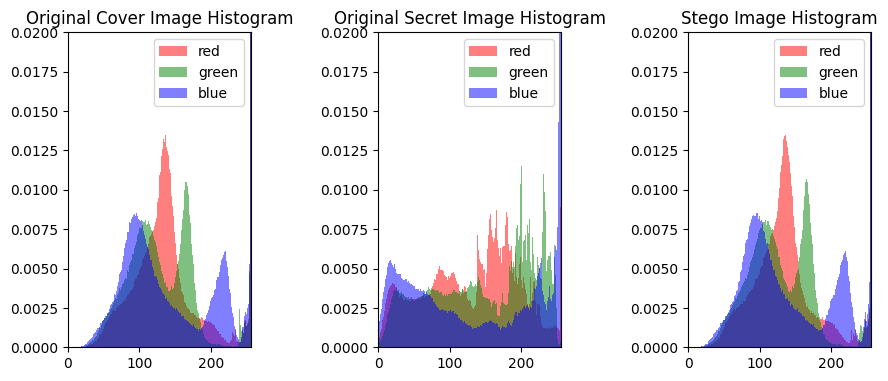

PSNR value: inf


In [10]:
import math
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def show_histograms(image1, title1, image2, title2, image3, title3):
    colors = ('red', 'green', 'blue')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))

    for channel, color in enumerate(colors):
        data1 = [pixel[channel] for pixel in image1.getdata()]
        data2 = [pixel[channel] for pixel in image2.getdata()]
        data3 = [pixel[channel] for pixel in image3.getdata()]
        ax1.hist(data1, bins=256, range=(0, 256), density=True, color=color, alpha=0.5, label=color)
        ax2.hist(data2, bins=256, range=(0, 256), density=True, color=color, alpha=0.5, label=color)
        ax3.hist(data3, bins=256, range=(0, 256), density=True, color=color, alpha=0.5, label=color)

    ax1.set_title(title1)
    ax1.set_xlim([0, 256])
    ax1.set_ylim([0, 0.02])
    ax1.legend()

    ax2.set_title(title2)
    ax2.set_xlim([0, 256])
    ax2.set_ylim([0, 0.02])
    ax2.legend()

    ax3.set_title(title3)
    ax3.set_xlim([0, 256])
    ax3.set_ylim([0, 0.02])
    ax3.legend()

    fig.tight_layout(pad=5)
    plt.show()

def load_image(image_path):
    return Image.open(image_path)

def perfect_square_thresholds(n):
    thresholds = [int(math.pow(i, 2)) for i in range(1, n+1)]
    return thresholds

def pvd(g, n, secret_bits):
    g = np.array(g, dtype=float)
    d = g[0] - g[1]
    dap = abs(d)

    d1 = dap

    lb = np.array(perfect_square_thresholds(n))[:-1]
    ub = np.array(perfect_square_thresholds(n))[1:] - 1

    for i in range(len(lb)):
        if lb[i] <= dap <= ub[i]:
            n = ub[i] - lb[i] + 1
            t = int(np.log2(n))
            d1 = secret_bits + lb[i]

    m = (abs(d1 - dap)) / 2

    if (g[0] >= g[1]) and (d1 > dap):
        p1 = g[0] + np.ceil(m)
        p2 = g[1] - np.floor(m)
    elif (g[0] < g[1]) and (d1 > dap):
        p1 = g[0] - np.floor(m)
        p2 = g[1] + np.ceil(m)
    elif (g[0] >= g[1]) and (d1 <= dap):
        p1 = g[0] - np.ceil(m)
        p2 = g[1] + np.floor(m)
    elif (g[0] < g[1]) and (d1 <= dap):
        p1 = g[0] + np.ceil(m)
        p2 = g[1] - np.floor(m)

    return p1, p2


def hide_image(cover_image, secret_image):
    width, height = cover_image.size
    thresholds = perfect_square_thresholds(8)

    for row in range(height - 1):
        for col in range(width - 1):
            p1 = cover_image.getpixel((col, row))
            p2 = cover_image.getpixel((col + 1, row))
            secret_pixel = secret_image.getpixel((col, row))

            p1_new = list(p1)
            p2_new = list(p2)

            for channel in range(3):
                secret_bits = secret_pixel[channel] // (2 * thresholds[-1])
                p1_new[channel], p2_new[channel] = pvd([p1[channel], p2[channel]], len(thresholds), secret_bits)

            cover_image.putpixel((col, row), tuple(map(int, p1_new)))
            cover_image.putpixel((col + 1, row), tuple(map(int,p2_new)))

    return cover_image

def inverse_pvd(g, n):
    g = np.array(g, dtype=float)
    d = g[0] - g[1]
    dap = abs(d)

    lb = np.array(perfect_square_thresholds(n))[:-1]
    ub = np.array(perfect_square_thresholds(n))[1:] - 1

    thresholds = perfect_square_thresholds(8)

    for i in range(len(lb)):
        if lb[i] <= dap <= ub[i]:
            n = ub[i] - lb[i] + 1
            t = int(np.log2(n))
            secret_bits = int((dap - lb[i]) * (2 * thresholds[-1]))

            return secret_bits

    return 0

def extract_secret_image(stego_image):
    width, height = stego_image.size
    secret_image = Image.new("RGB", stego_image.size)

    thresholds = perfect_square_thresholds(8)

    for row in range(height - 1):
        for col in range(width - 1):
            p1 = stego_image.getpixel((col, row))
            p2 = stego_image.getpixel((col + 1, row))

            secret_pixel = [0, 0, 0]

            for channel in range(3):
                secret_bits = inverse_pvd([p1[channel], p2[channel]], len(thresholds))
                secret_pixel[channel] = secret_bits

            secret_image.putpixel((col, row), tuple(secret_pixel))

    return secret_image


def psnr(img1, img2):
    img1_np = np.array(img1, dtype=np.float64)
    img2_np = np.array(img2, dtype=np.float64)

    mse = np.mean((img1_np - img2_np) ** 2)

    if mse == 0:
        return float('inf')

    max_pixel = 255.0
    psnr_value = 10 * np.log10((max_pixel ** 2) / mse)

    return psnr_value


cover_image = load_image('filtered_1/00000000_(4).jpg.')
secret_image = load_image('filtered_1/00000045_(2).jpg')

stego_image = hide_image(cover_image, secret_image)
stego_image.save('stego_image.png')


extracted_secret_image = extract_secret_image(stego_image)
extracted_secret_image.save("extracted_secret_image.png")

show_histograms(cover_image, 'Original Cover Image Histogram', secret_image,
                'Original Secret Image Histogram', stego_image, 'Stego Image Histogram')
print('PSNR value:', psnr(cover_image, stego_image))